Gradient Checking for backbone propagation 

In [34]:
import numpy as np
from lib.layers import Dense
from lib.activations import Tanh
from lib.losses import mse_loss
from lib.network import Network


In [35]:
np.random.seed(42)

X = np.random.randn(5, 3)      # batch=5, input=3
y = np.random.randn(5, 4)      # output=4


In [36]:
layer = Dense(3, 4)
activation = Tanh()

# Forward pass
Z = layer.forward(X)
A = activation.forward(Z)

loss, dA = mse_loss(y, A)

# Backward pass
dZ = activation.backward(dA)
layer.backward(dZ)

dW_analytical = layer.dW.copy()


In [37]:
epsilon = 1e-5
dW_numerical = np.zeros_like(layer.W)

for i in range(layer.W.shape[0]):
    for j in range(layer.W.shape[1]):

        W_original = layer.W[i, j]

        # W + epsilon
        layer.W[i, j] = W_original + epsilon
        loss_plus, _ = mse_loss(y, activation.forward(layer.forward(X)))

        # W - epsilon
        layer.W[i, j] = W_original - epsilon
        loss_minus, _ = mse_loss(y, activation.forward(layer.forward(X)))

        # Numerical gradient
        dW_numerical[i, j] = (loss_plus - loss_minus) / (2 * epsilon)

        # Restore weight
        layer.W[i, j] = W_original


In [38]:
difference = np.linalg.norm(dW_analytical - dW_numerical)
norm = np.linalg.norm(dW_analytical) + np.linalg.norm(dW_numerical)
relative_error = difference / norm

print("Analytical Gradient:\n", dW_analytical)
print("Numerical Gradient:\n", dW_numerical)
print("Relative Error:", relative_error)


Analytical Gradient:
 [[ 1.10717885 -0.34308103  0.38517306  0.4123532 ]
 [ 0.63711027  0.2944879  -0.59413469  1.06305687]
 [ 0.0228264   0.35383937 -0.84594782  0.52178788]]
Numerical Gradient:
 [[ 1.10717885 -0.34308103  0.38517306  0.4123532 ]
 [ 0.63711027  0.2944879  -0.59413469  1.06305687]
 [ 0.0228264   0.35383937 -0.84594782  0.52178788]]
Relative Error: 3.633731913633675e-11


Numerical gradient checking was performed on the Dense layer using finite
difference approximation. The analytical gradients computed through
backpropagation matched the numerical gradients with a relative error of
3.63 × 10⁻¹¹, confirming the correctness of the backpropagation
implementation.

PART1: XOR 

In [ ]:
import sys
print(sys.executable)


In [ ]:
# imports
import sys
import os
import time
time.sleep(0.1)

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Ensure Python can find the lib folder
sys.path.append(os.path.abspath(".."))

# Import your library
from lib.layers import Dense
from lib.activations import Tanh, Sigmoid
from lib.network import Network
from lib.losses import mse_loss
from lib.optimizer import SGD

print("Imports successful")


In [ ]:
# XOR dataset
X = np.array([
    [0,0],
    [0,1],
    [1,0],
    [1,1]
], dtype=float)

y = np.array([[0],[1],[1],[0]], dtype=float)

print("XOR dataset:")
print(X)
print(y)


In [ ]:
# Build the network
layers = [
    Dense(2, 4),  
    Tanh(),
    Dense(4, 1),
    Sigmoid()
]

# Use SGD optimizer
model = Network(layers, optimizer=SGD(lr=0.5))

print("Model created successfully")


In [ ]:
# Training
epochs = 20000  
losses = model.fit(X, y, mse_loss, epochs=epochs)

# Plot loss curve
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("XOR Training Loss")
plt.grid(True)
plt.show()


In [ ]:
# Final predictions
preds = model.forward(X)

print("Predictions:")
print(preds)

print("\nRounded predictions (0/1):")
print((preds > 0.5).astype(int))


PART 2:Autoencoder training

In [1]:
import sys
import os

# Add project root to Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print("Project root added to sys.path:", project_root)




Project root added to sys.path: c:\Users\marya\Downloads\CI_proj


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

from lib.layers import Dense
from lib.activations import ReLU, Sigmoid
from lib.network import Network
from lib.losses import mse_loss
from lib.optimizer import SGD


In [3]:
# Load MNIST
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Normalize to [0,1] and flatten
X_train = X_train.reshape(-1, 28*28) / 255.0
X_test = X_test.reshape(-1, 28*28) / 255.0

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (60000, 784)
Test shape: (10000, 784)


In [4]:
input_dim = 28*28
latent_dim = 64  # small latent space

encoder_layers = [
    Dense(input_dim, 128),
    ReLU(),
    Dense(128, latent_dim),
    ReLU()
]

decoder_layers = [
    Dense(latent_dim, 128),
    ReLU(),
    Dense(128, input_dim),
    Sigmoid()  # output in [0,1]
]

autoencoder_layers = encoder_layers + decoder_layers

autoencoder = Network(autoencoder_layers, optimizer=SGD(lr=0.05))


In [5]:
epochs = 50
batch_size = 128
loss_history = []

for epoch in range(epochs):
    perm = np.random.permutation(X_train.shape[0])
    X_train_shuffled = X_train[perm]
    
    for i in range(0, X_train.shape[0], batch_size):
        X_batch = X_train_shuffled[i:i+batch_size]
        y_batch = X_batch  # unsupervised
        
        y_pred = autoencoder.forward(X_batch)
        loss, grad = mse_loss(y_batch, y_pred)
        autoencoder.backward(grad)
        autoencoder.optimizer.step(autoencoder.params())
    
    # Compute full epoch loss
    y_pred_full = autoencoder.forward(X_train)
    epoch_loss, _ = mse_loss(X_train, y_pred_full)
    loss_history.append(epoch_loss)
    print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss}")


Epoch 1/50 - Loss: 25.150173448864923
Epoch 2/50 - Loss: 16.61563325823313
Epoch 3/50 - Loss: 13.452660653592222
Epoch 4/50 - Loss: 12.357651267273999
Epoch 5/50 - Loss: 10.254731683640667
Epoch 6/50 - Loss: 10.437428502712756
Epoch 7/50 - Loss: 9.750856793347564
Epoch 8/50 - Loss: 10.456438004763477
Epoch 9/50 - Loss: 8.620008881365504
Epoch 10/50 - Loss: 9.647499774597073
Epoch 11/50 - Loss: 8.98630205175503
Epoch 12/50 - Loss: 9.67929507695267
Epoch 13/50 - Loss: 8.63474098740082
Epoch 14/50 - Loss: 8.126699442874942
Epoch 15/50 - Loss: 7.762064387684999
Epoch 16/50 - Loss: 7.317251877144834
Epoch 17/50 - Loss: 7.363712437290512
Epoch 18/50 - Loss: 8.366159259994086
Epoch 19/50 - Loss: 7.180100906578635
Epoch 20/50 - Loss: 7.466984591233229
Epoch 21/50 - Loss: 7.315230476979756
Epoch 22/50 - Loss: 7.544838455877351
Epoch 23/50 - Loss: 7.614010747307819
Epoch 24/50 - Loss: 6.439746918087882
Epoch 25/50 - Loss: 6.759136713523685
Epoch 26/50 - Loss: 6.646330514912919
Epoch 27/50 - Loss

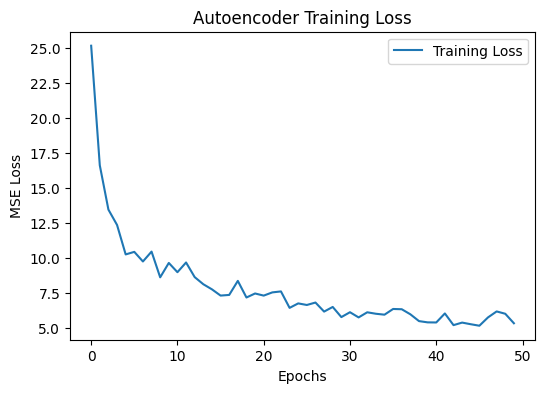

In [6]:
plt.figure(figsize=(6,4))
plt.plot(loss_history, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("Autoencoder Training Loss")
plt.legend()
plt.show()


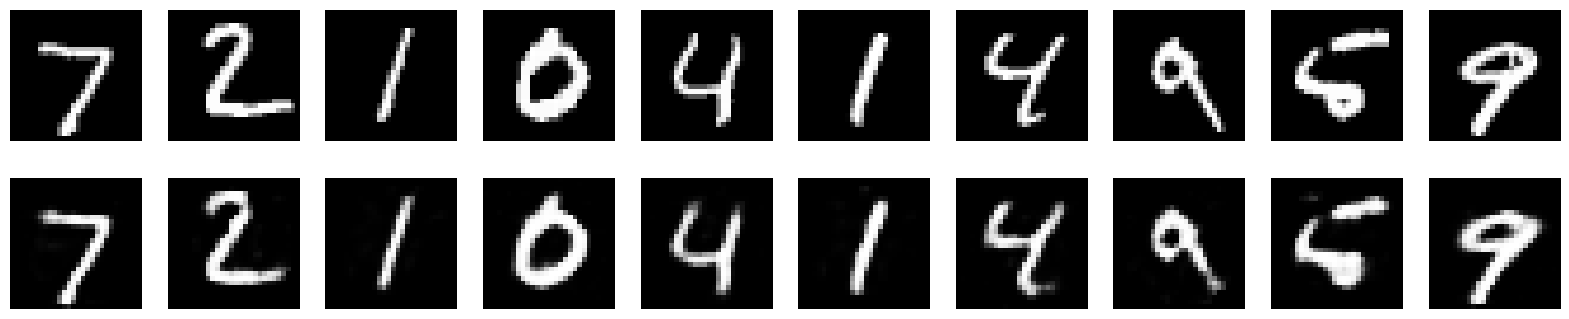

In [7]:
n = 10
X_sample = X_test[:n]
reconstructions = autoencoder.forward(X_sample)

plt.figure(figsize=(20,4))
for i in range(n):
    # Original
    plt.subplot(2, n, i+1)
    plt.imshow(X_sample[i].reshape(28,28), cmap='gray')
    plt.axis('off')
    
    # Reconstructed
    plt.subplot(2, n, i+n+1)
    plt.imshow(reconstructions[i].reshape(28,28), cmap='gray')
    plt.axis('off')
plt.show()


Latent Space SVM Classification and training

In [8]:
# Encoder forward function only
def encode(X):
    out = X
    for layer in encoder_layers:  # use the encoder part only
        out = layer.forward(out)
    return out

# Transform train and test data into latent space
X_train_latent = encode(X_train)
X_test_latent = encode(X_test)

print("Latent space shape (train):", X_train_latent.shape)
print("Latent space shape (test) :", X_test_latent.shape)


Latent space shape (train): (60000, 64)
Latent space shape (test) : (10000, 64)


In [9]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Train SVM on latent features
svm_clf = SVC(kernel='rbf', gamma='scale')
svm_clf.fit(X_train_latent, y_train)

# Predict on test set
y_pred_svm = svm_clf.predict(X_test_latent)

# Accuracy
acc = accuracy_score(y_test, y_pred_svm)
print("SVM Test Accuracy:", acc)


SVM Test Accuracy: 0.9826


In [10]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_svm)
print("Confusion Matrix:\n", cm)

# Full classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm))


Confusion Matrix:
 [[ 972    0    2    0    0    1    2    1    2    0]
 [   0 1128    3    1    0    1    1    0    1    0]
 [   3    1 1007    4    1    0    2    7    7    0]
 [   0    0    1  994    0    3    0    6    4    2]
 [   0    0    5    0  964    0    1    0    2   10]
 [   2    0    0    5    0  881    2    0    1    1]
 [   4    2    0    1    2    3  943    0    3    0]
 [   1    5    6    0    0    0    0 1008    2    6]
 [   3    0    1    4    2    4    1    4  953    2]
 [   4    4    1    6    8    3    0    5    2  976]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.99      0.98      0.98       982
           5       0.98      0.99      0.99       892
           6       0.99      0.98      0.99   

TensorFlow/Keras Comparison

XOR comparison

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import MeanSquaredError

import numpy as np
import time


In [14]:
# XOR dataset
X_xor = np.array([[0,0],[0,1],[1,0],[1,1]])
y_xor = np.array([[0],[1],[1],[0]])

# Build XOR model
xor_model = Sequential([
    Dense(4, input_dim=2, activation='tanh'),
    Dense(1, activation='sigmoid')
])

xor_model.compile(optimizer=SGD(learning_rate=0.1), loss='mse')

# Train XOR model
start_time = time.time()
xor_model.fit(X_xor, y_xor, epochs=2000, verbose=0)
xor_time = time.time() - start_time

# Predictions
y_pred_xor = xor_model.predict(X_xor)
print("XOR predictions (Keras):\n", y_pred_xor)
print(f"XOR training time: {xor_time:.4f} seconds")


1/1 [==============================] - 0s 289ms/step
XOR predictions (Keras):
 [[0.05083403]
 [0.90982074]
 [0.9127891 ]
 [0.09597579]]
XOR training time: 12.8768 seconds


Autoencoder in keras

In [32]:
# Autoencoder architecture (same as your library)
input_dim = 28*28
latent_dim = 128

# Build Keras autoencoder
keras_autoencoder = Sequential([
    Dense(128, activation='relu', input_shape=(input_dim,)),
    Dense(latent_dim, activation='relu', name='encoder'),
    Dense(128, activation='relu'),
    Dense(input_dim, activation='sigmoid')
])

keras_autoencoder.compile(optimizer=SGD(learning_rate=0.05), loss=MeanSquaredError())

# Train Keras autoencoder
start_time = time.time()
history = keras_autoencoder.fit(X_train, X_train, epochs=100, batch_size=256, verbose=1)
keras_time = time.time() - start_time

# Reconstruction loss on test set
reconstructions = keras_autoencoder.predict(X_test)
mse = np.mean((X_test - reconstructions)**2)
print(f"Keras Autoencoder Test MSE: {mse:.4f}")
print(f"Keras Autoencoder training time: {keras_time:.2f} seconds")


Epoch 1/100
235/235 [==============================] - 4s 13ms/step - loss: 0.2299
Epoch 2/100
235/235 [==============================] - 3s 13ms/step - loss: 0.2260
Epoch 3/100
235/235 [==============================] - 4s 18ms/step - loss: 0.2169
Epoch 4/100
235/235 [==============================] - 4s 15ms/step - loss: 0.1853
Epoch 5/100
235/235 [==============================] - 3s 15ms/step - loss: 0.1179
Epoch 6/100
235/235 [==============================] - 3s 14ms/step - loss: 0.0812
Epoch 7/100
235/235 [==============================] - 4s 15ms/step - loss: 0.0742
Epoch 8/100
235/235 [==============================] - 4s 16ms/step - loss: 0.0723
Epoch 9/100
235/235 [==============================] - 4s 18ms/step - loss: 0.0714
Epoch 10/100
235/235 [==============================] - 4s 16ms/step - loss: 0.0710
Epoch 11/100
235/235 [==============================] - 4s 17ms/step - loss: 0.0707
Epoch 12/100
235/235 [==============================] - 4s 15ms/step - loss: 0.0704
E

In [33]:
# Extract latent features using encoder layer
encoder_model = tf.keras.Model(inputs=keras_autoencoder.input,
                               outputs=keras_autoencoder.get_layer('encoder').output)

X_train_latent_keras = encoder_model.predict(X_train)
X_test_latent_keras = encoder_model.predict(X_test)

# Train SVM on Keras latent features
svm_keras = SVC(kernel='rbf', gamma='scale')
svm_keras.fit(X_train_latent_keras, y_train)

y_pred_svm_keras = svm_keras.predict(X_test_latent_keras)
acc_keras = accuracy_score(y_test, y_pred_svm_keras)
print("SVM Accuracy on Keras latent features:", acc_keras)


313/313 [==============================] - 1s 3ms/step
SVM Accuracy on Keras latent features: 0.9061


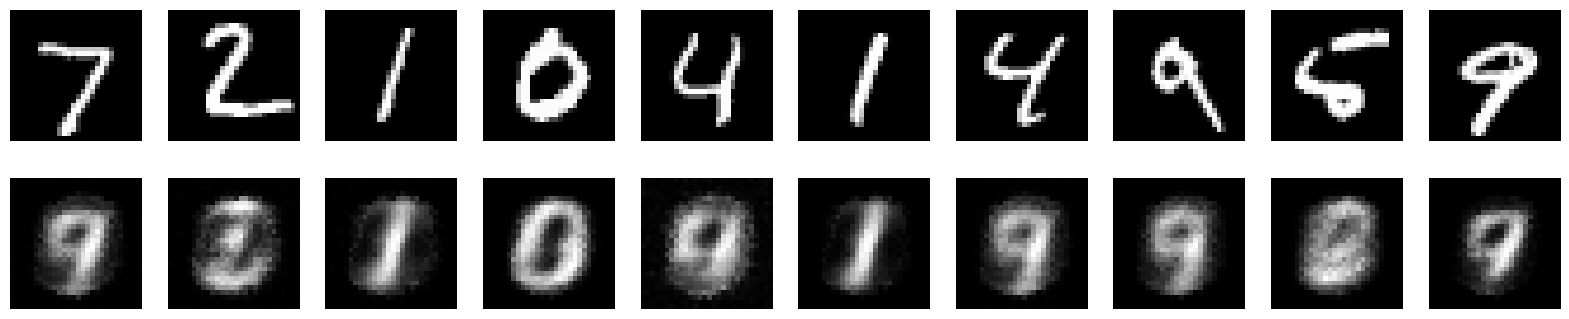

In [39]:
#Visuals
n = 10
plt.figure(figsize=(20,4))
for i in range(n):
    # Original
    plt.subplot(2, n, i+1)
    plt.imshow(X_test[i].reshape(28,28), cmap='gray')
    plt.axis('off')
    
    # Reconstructed (Keras)
    plt.subplot(2, n, i+n+1)
    plt.imshow(reconstructions[i].reshape(28,28), cmap='gray')
    plt.axis('off')
plt.show()
